Задание:
Эксперимент проходил с 2023-07-30 по 2023-08-05 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Ваша задача — проанализировать данные А/B-теста. 
Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) 
а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

План решения:
1. Проведение А/А тест
2. Построение гистограммы распределения целевой метрики для обеих групп
3. Выбор теста и его реализация
4. Выводы    

In [1]:
import pandahouse 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

1. Проведение А/А теста 

In [7]:
# Загрузка датасета за заданный промежуток времени для 1 и 2 групп до начала теста
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230820'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-23' and '2023-07-29'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df1 = pandahouse.read_clickhouse(q, connection=connection)
df1.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,10,34,0.294118
1,1,18392,13,56,0.232143
2,2,131473,19,98,0.193878
3,2,23985,12,44,0.272727
4,2,24523,2,10,0.200000


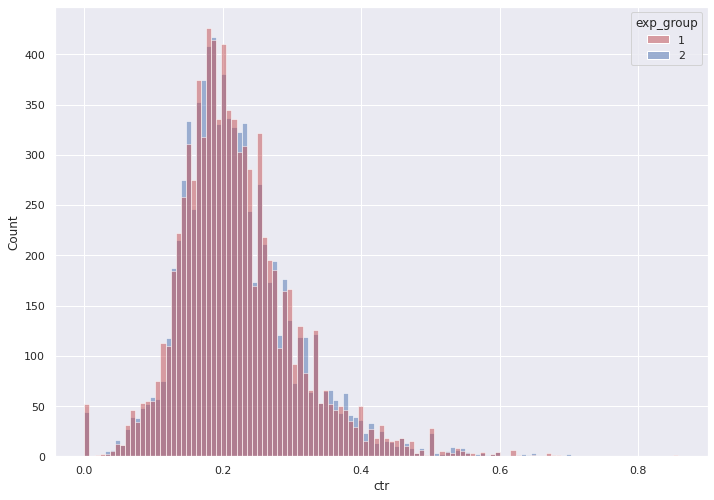

In [9]:
# Построим графики в seaborn для сравнения распределения ctr обеих групп до начала теста
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df1, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [10]:
stats.ttest_ind(df1[df1.exp_group == 1].ctr,
                df1[df1.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.5694920635629134, pvalue=0.5690298477939706)

Вывод А/А теста.
Проверила распределение целевой метрики для тестовой и контрольной группы до  начала эксперимента:
как гистограмма, так и т-тест показали, что нет оснований отклонить нулевую гипотезу о равенстве выборок, значит делаем вывод о том, что распределение целевой метрики для обеих группп одинаково. Переходим к оценке результатов эксперимента.

In [3]:
# Загрузка датасета за заданный промежуток времени для 1 и 2 групп и сравнение распределения признаков
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230820'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596


In [5]:
# Сравним наши группы по количесву уникальных пользователей
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


2. Построение гистограммы распределения целевой метрики для обеих групп

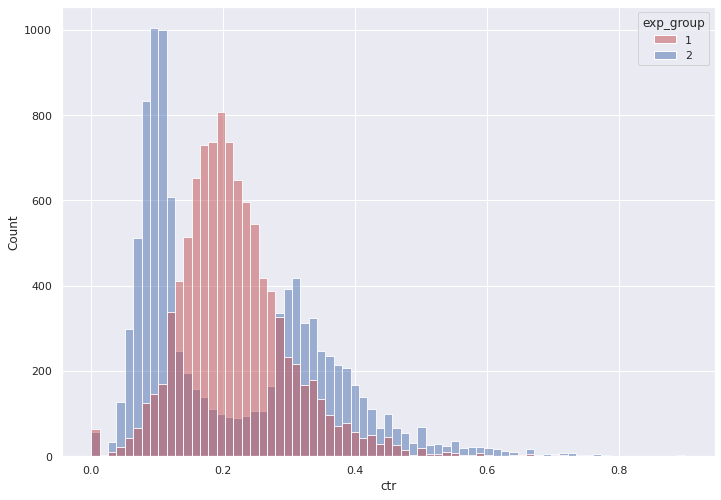

In [14]:
# Построим графики в seaborn для сравнения распределения ctr обеих групп
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

3. Выбор теста и его реализация

На построенной гистограмме видим, что распределения метрики для тестовой и контрольной группы отличаются: распределение для контрольной группы визуально близко к нормальному и имеет одну моду, тогда как распределение для тестовой группы бимодально. 

Выбор теста для оценки результатов эксперимента.
Т-тест не подходит так как распределение целевой метрики в тестовой группе отличается от нормального.
Воспользуемся его непараметрическим аналогом: тестом Манна-Уитни

In [11]:
# Рассчитываем статистику
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [12]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A < B. Должно получиться около 50%')

В 55.91 % случаев A > B. Должно получиться около 50%


Интересно, что покажет т-тест

In [13]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

4. Выводы  

Также хочется отметить, что бимодальное распределение говорит о том, что есть большое число пользователей, имеющих высокий ctr и большое число пользователей с низким ctr. Значит, изменение вызвало крайне полярную реакцию пользователей, вероятно, оно было кардинально отличающимся от первоначального (это мог быть совершенно новый дизайн, изменение привычного местоположения, цветовая гамма, новый функционал) .
По результатам теста Манна-Уитни нет оснований отклонить нулевую гипотезу, которая звучит как не равенство средних, не равенство медиан и так далее, значит принимаем альтернативную гипотезу о их равенстве.
Т-тест (несмотря на то, что он не совсем подходит в данном случае) показал, что нет оснований отклонить нулевую гипотезу о равенстве средних.
По результатам эксперимента нет оснований полагать, что новый алгоритм лучше существующего, и по полученным данным нет оснований для его раскатки на всех пользователей. Я бы рекомендовала продлить эксперимент на еще 1 неделю и посмотреть результаты и уже на основании их делать окончательные выводы, особенно если изменение кардинальное.